# Imports & Load data



In [126]:
import os
from os.path import join as pjoin

import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import roc_auc_score
import xgboost as xgb

In [127]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA


In [128]:
# feature selection
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif,chi2
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectFromModel,RFECV
from sklearn.preprocessing import Binarizer, scale,normalize

In [226]:
import warnings
warnings.filterwarnings('ignore')

In [129]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,8)

In [263]:
train = pd.read_csv('../data/train.csv')

In [264]:
test = pd.read_csv('../data/test.csv')

# Helper functions

In [132]:
def split(x,n=None):
    if n==None:
        n=int(len(x)*.7)
    
    return x[:n],x[n:]

# Provide a place holder for train
def split_data(df):
    y = df['TARGET'].copy()
    x = df.drop('TARGET',axis=1)
    global X_train,X_valid,y_train,y_valid
    
    X_train ,X_valid = split(x)
    y_train ,y_valid = split(y)

In [133]:

def eval(clf):
    train_pred = clf.predict(X_train)
    valid_pred = clf.predict(X_valid)
    if train_pred.sum()==0:
        print("All prediciton on train is 0")
        
    if valid_pred.sum()==0:
        print("All prediciton on valid is 0")
    print('ROC on training set : ',roc_auc_score(y_train,train_pred))
    print('ROC on valid set : ',roc_auc_score(y_valid,valid_pred))
    
    

In [134]:
def plot_fi(clf,n_top=30):
    fi = pd.DataFrame({'cols':X_train.columns,'fi':clf.feature_importances_}).sort_values('fi',ascending=False)
    fi.iloc[:n_top].plot(x='cols',y='fi',kind='barh')
    return list(fi.cols.values)
    

In [135]:
def base_model():
    clf = RFC(criterion='gini', class_weight='balanced', max_depth=10,random_state=1)
    clf.fit(X_train,y_train)
    eval(clf)

# Data walkthrough

In [136]:
train.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [137]:
train.shape

(76020, 371)

In [138]:
train.columns

Index(['ID', 'var3', 'var15', 'imp_ent_var16_ult1', 'imp_op_var39_comer_ult1',
       'imp_op_var39_comer_ult3', 'imp_op_var40_comer_ult1',
       'imp_op_var40_comer_ult3', 'imp_op_var40_efect_ult1',
       'imp_op_var40_efect_ult3',
       ...
       'saldo_medio_var33_hace2', 'saldo_medio_var33_hace3',
       'saldo_medio_var33_ult1', 'saldo_medio_var33_ult3',
       'saldo_medio_var44_hace2', 'saldo_medio_var44_hace3',
       'saldo_medio_var44_ult1', 'saldo_medio_var44_ult3', 'var38', 'TARGET'],
      dtype='object', length=371)

In [139]:
train.isnull().sum()

ID                               0
var3                             0
var15                            0
imp_ent_var16_ult1               0
imp_op_var39_comer_ult1          0
imp_op_var39_comer_ult3          0
imp_op_var40_comer_ult1          0
imp_op_var40_comer_ult3          0
imp_op_var40_efect_ult1          0
imp_op_var40_efect_ult3          0
imp_op_var40_ult1                0
imp_op_var41_comer_ult1          0
imp_op_var41_comer_ult3          0
imp_op_var41_efect_ult1          0
imp_op_var41_efect_ult3          0
imp_op_var41_ult1                0
imp_op_var39_efect_ult1          0
imp_op_var39_efect_ult3          0
imp_op_var39_ult1                0
imp_sal_var16_ult1               0
ind_var1_0                       0
ind_var1                         0
ind_var2_0                       0
ind_var2                         0
ind_var5_0                       0
ind_var5                         0
ind_var6_0                       0
ind_var6                         0
ind_var8_0          

# Feature engineering

## Drop skewed columns

In [265]:
skew_cols = []
for col in train.columns:
    train_cnt = train[col].value_counts().sort_values(ascending=False)/len(train)
    if train_cnt.values[0]>0.999:
        skew_cols.append(col)
        
train.drop(skew_cols,axis=1,inplace=True)        
test.drop(skew_cols,axis=1,inplace=True)
print(f'{len(skew_cols)} columns with skewed value')

146 columns with skewed value


## Drop duplicate columns

In [266]:
columnsdup_cols = []
for col_1 in train.columns:
    v = train[col_1].values
    for col_2 in train.columns:
        #if col_1 != col_2 and train[col_1].sum() == train[col_2].sum():
        if col_1 != col_2:
            if np.array_equal(train[col_1],train[col_2]):
                dup_cols.append(col_2)
train.drop(dup_cols,axis=1,inplace=True)        
test.drop(dup_cols,axis=1,inplace=True)
print(f'{len(dup_cols)} columns with duplicate value')

80 columns with duplicate value


## Var3 bug

In [267]:
train['var3'].replace(-999999,0, inplace=True)
test['var3'].replace(-999999,0, inplace=True)

## ID

In [268]:
train.drop('ID',axis=1,inplace=True)
test_id = test.ID
test.drop('ID',axis=1,inplace=True)

## Adding PCA

In [269]:
train.shape

(76020, 204)

In [270]:
pca = PCA(n_components=3)
x_train_projected = pca.fit_transform(normalize(train.drop('TARGET',axis=1), axis=0))
x_test_projected = pca.transform(normalize(test, axis=0))
print(pca.explained_variance_ratio_)
train.insert(1, 'PCA1', x_train_projected[:, 0])
train.insert(1, 'PCA2', x_train_projected[:, 1])
train.insert(1, 'PCA3', x_train_projected[:, 2])

test.insert(1, 'PCA1', x_test_projected[:, 0])
test.insert(1, 'PCA2', x_test_projected[:, 1])
test.insert(1, 'PCA3', x_test_projected[:, 2])


[0.11167207 0.08418294 0.0609069 ]


## Feature selection
SelectKBest will return top k features

SelectPercentile will return a sub set of your features

### Filter method

In [231]:
ps = [40,45,50,55,60,65,70,75,80,85,90,95]

In [232]:
for p in ps :
    split_data(train)
    # Preprocessing
    X = pd.concat([X_train,X_valid])
    X_bin = Binarizer().fit_transform(scale(X))
    y_ = pd.concat([y_train,y_valid])

    # get the columns
    selectChi2 = SelectPercentile(chi2, percentile=p).fit(X_bin, y_)
    selected_cols = list(X_train.columns[selectChi2.get_support()].values) + ["TARGET"]
    
    # test
    split_data(train[selected_cols])
    clf = RFC(criterion='gini', class_weight='balanced', max_depth=10,random_state=1)
    clf.fit(X_train,y_train)
    print('-'*100)
    print(p)
    print(len(selected_cols))
    eval(clf)
    


----------------------------------------------------------------------------------------------------
40
84
ROC on training set :  0.7987841512685709
ROC on valid set :  0.7553808547445271
----------------------------------------------------------------------------------------------------
45
94
ROC on training set :  0.798433120023654
ROC on valid set :  0.7546725009328041
----------------------------------------------------------------------------------------------------
50
104
ROC on training set :  0.8013308549641129
ROC on valid set :  0.7554512210172148
----------------------------------------------------------------------------------------------------
55
115
ROC on training set :  0.7966360080626856
ROC on valid set :  0.7614396434198154
----------------------------------------------------------------------------------------------------
60
125
ROC on training set :  0.8033863534420225
ROC on valid set :  0.7557943919163226
----------------------------------------------------------

Test results

In [271]:
p = 60

split_data(train)
# Preprocessing
X = pd.concat([X_train,X_valid])
X_bin = Binarizer().fit_transform(scale(X))
y_ = pd.concat([y_train,y_valid])

# get the columns
selectChi2 = SelectPercentile(chi2, percentile=p).fit(X_bin, y_)
selected_cols = list(X_train.columns[selectChi2.get_support()].values)
selected_cols

['var3',
 'PCA3',
 'PCA2',
 'PCA1',
 'var15',
 'imp_op_var41_efect_ult1',
 'imp_op_var41_efect_ult3',
 'imp_op_var39_efect_ult1',
 'imp_op_var39_efect_ult3',
 'imp_sal_var16_ult1',
 'ind_var1',
 'ind_var5',
 'ind_var8_0',
 'ind_var8',
 'ind_var12_0',
 'ind_var12',
 'ind_var13_0',
 'ind_var13_corto_0',
 'ind_var13_corto',
 'ind_var13_largo_0',
 'ind_var13_largo',
 'ind_var13',
 'ind_var14_0',
 'ind_var19',
 'ind_var20_0',
 'ind_var20',
 'ind_var24_0',
 'ind_var24',
 'ind_var25_cte',
 'ind_var26_cte',
 'ind_var30',
 'ind_var31_0',
 'ind_var39_0',
 'ind_var41_0',
 'num_var1',
 'num_var4',
 'num_var5',
 'num_var8_0',
 'num_var8',
 'num_var12_0',
 'num_var12',
 'num_var13_0',
 'num_var13_corto_0',
 'num_var13_corto',
 'num_var13_largo_0',
 'num_var13_largo',
 'num_var13',
 'num_var14_0',
 'num_var20_0',
 'num_var20',
 'num_var24_0',
 'num_var24',
 'num_var30_0',
 'num_var30',
 'num_var31_0',
 'num_var35',
 'num_var39_0',
 'num_var41_0',
 'num_var42_0',
 'num_var42',
 'saldo_var1',
 'saldo_v

In [273]:
train = train[selected_cols + ['TARGET']]
test = test[selected_cols]

### Wrapper methods



In [119]:
clf = RFC(criterion='gini', class_weight='balanced', max_depth=10,random_state=1)
clf.fit(X_train,y_train)
eval(clf)

/Users/macbook/miniconda3/envs/dev/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ROC on training set :  0.8159160278600914
ROC on valid set :  0.7446744278861178


Tested with step = 1/2 . step 2 return better score

In [82]:
# step is how many feature to remove at a time
dtree_rfe = RFECV(clf, step=2,scoring = 'roc_auc', cv = 5) 
dtree_rfe.fit(X_train,y_train)

RFECV(cv=5,
   estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=None, oob_score=False, random_state=1,
            verbose=0, warm_start=False),
   min_features_to_select=1, n_jobs=None, scoring='roc_auc', step=1,
   verbose=0)

In [97]:
rfecv_step_2 = list(rfecv_step_2) + ['TARGET']

In [112]:
split_data(train[rfecv_step_2])

In [113]:
clf = RFC(criterion='gini', class_weight='balanced', max_depth=10,random_state=1)
clf.fit(X_train,y_train)
eval(clf)

/Users/macbook/miniconda3/envs/dev/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ROC on training set :  0.8159160278600914
ROC on valid set :  0.7446744278861178


# Modeling

## RandomForest

Note: for sparse data include class_weight will handle it

In [274]:
split_data(train)

Tried with these params : n_estimators=30,min_samples_leaf=10,max_features='log2',n_jobs=-1

The model predict all samples are 0 => extremely overfit

In [280]:
clf = RFC(criterion='gini', class_weight='balanced', max_depth=10,random_state=1)
clf.fit(X_train,y_train)
eval(clf)

ROC on training set :  0.800327143558722
ROC on valid set :  0.7515382067209534


In [281]:
X_train.columns

Index(['var3', 'PCA3', 'PCA2', 'PCA1', 'var15', 'imp_op_var41_efect_ult1',
       'imp_op_var41_efect_ult3', 'imp_op_var39_efect_ult1',
       'imp_op_var39_efect_ult3', 'imp_sal_var16_ult1',
       ...
       'saldo_medio_var12_ult3', 'saldo_medio_var13_corto_hace2',
       'saldo_medio_var13_corto_hace3', 'saldo_medio_var13_corto_ult1',
       'saldo_medio_var13_corto_ult3', 'saldo_medio_var13_largo_hace2',
       'saldo_medio_var13_largo_hace3', 'saldo_medio_var13_largo_ult1',
       'saldo_medio_var13_largo_ult3', 'var38'],
      dtype='object', length=123)

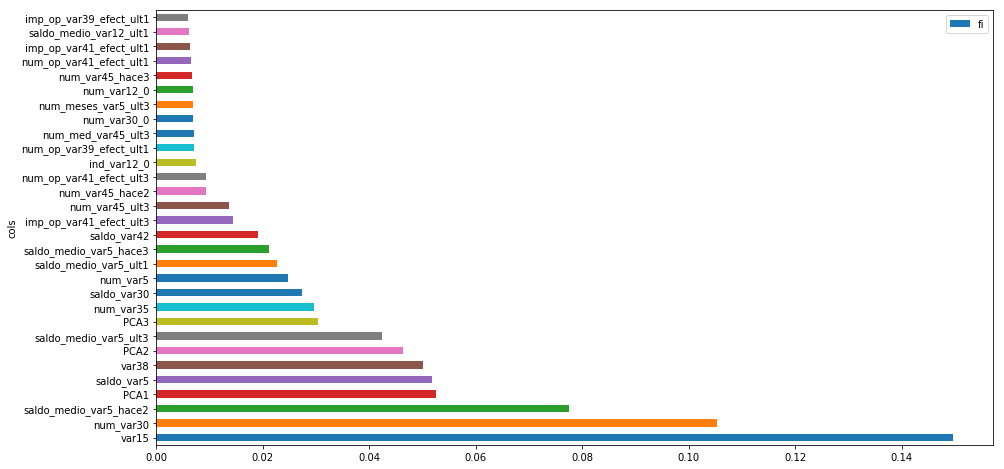

In [282]:
imp_cols = plot_fi(clf)

Why the fuck ID is the most important feature.? This is probaly wrong

### Using feature important

In [295]:
split_data(train[imp_cols[:40] +['TARGET']])

In [296]:
clf = RFC(criterion='gini', class_weight='balanced', max_depth=10,random_state=1)
clf.fit(X_train,y_train)
eval(clf)

ROC on training set :  0.8124310361492241
ROC on valid set :  0.7562938120260652


look better

In [297]:
train = train[imp_cols[:40] +['TARGET']]
test = [imp_cols[:40]]

## XGBoost
Let's try with xgboost

In [309]:
split_data(train)

In [310]:
clf = xgb.XGBClassifier(max_depth = 5,
                n_estimators=525,
                learning_rate=0.02, 
                nthread=4,
                subsample=0.95,
                colsample_bytree=0.85, 
                seed=4242)

In [311]:
clf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.85, gamma=0, learning_rate=0.02,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=525, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=4242, silent=True, subsample=0.95)

In [312]:
eval(clf)

ROC on training set :  0.5072921730675741
ROC on valid set :  0.4999771219400595


## LightGBM

# alo

In [221]:
import matplotlib.pyplot as plt

(60816, 306) (15204, 306) (75818, 306)


/Users/macbook/miniconda3/envs/dev/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


(60816, 36) (15204, 36) (75818, 36)
Roc AUC:  0.8316521354856642


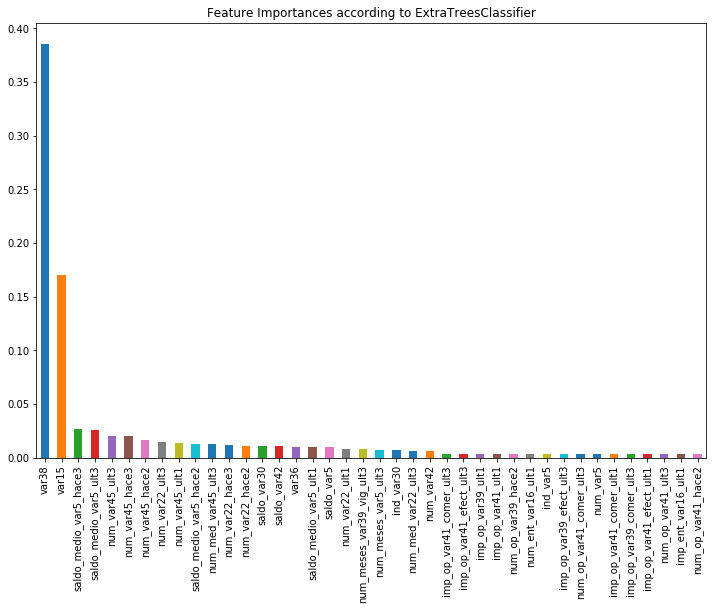

In [227]:
# clean and split data

# remove constant columns (std = 0)
remove = []
for col in train.columns:
    if train[col].std() == 0:
        remove.append(col)

train.drop(remove, axis=1, inplace=True)
test.drop(remove, axis=1, inplace=True)

# remove duplicated columns
remove = []
cols = train.columns
for i in range(len(cols)-1):
    v = train[cols[i]].values
    for j in range(i+1,len(cols)):
        if np.array_equal(v,train[cols[j]].values):
            remove.append(cols[j])

train.drop(remove, axis=1, inplace=True)
test.drop(remove, axis=1, inplace=True)

X = train.drop(["TARGET","ID"],axis=1)
y = train.TARGET.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1729)
print(X_train.shape, X_test.shape, test.shape)

## # Feature selection
clf = ExtraTreesClassifier(random_state=1729)
selector = clf.fit(X_train, y_train)

# plot most important features
feat_imp = pd.Series(clf.feature_importances_, index = X_train.columns.values).sort_values(ascending=False)
feat_imp[:40].plot(kind='bar', title='Feature Importances according to ExtraTreesClassifier', figsize=(12, 8))

# clf.feature_importances_ 
fs = SelectFromModel(selector, prefit=True)

X_train = fs.transform(X_train)
X_test = fs.transform(X_test)
test = fs.transform(test)

print(X_train.shape, X_test.shape, test.shape)

## # Train Model
# classifier from xgboost
m2_xgb = xgb.XGBClassifier(n_estimators=110, nthread=-1, max_depth = 4, \
seed=1729)
m2_xgb.fit(X_train, y_train, eval_metric="auc", verbose = False,
           eval_set=[(X_test, y_test)])

# calculate the auc score
print("Roc AUC: ", roc_auc_score(y_test, m2_xgb.predict_proba(X_test)[:,1],
              average='macro'))